In [1]:
from datetime import datetime
import os
import itertools
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from tqdm import tqdm

%matplotlib inline

In [2]:
class Config:
    seed = 2023
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    curr_dirpath = Path(os.getcwd())
    repo_dirpath = curr_dirpath / "../"
    dataset_dirpath = repo_dirpath / "input"
    ts_identifier_col = "store_item"
    ts_col = "date"
    target_col = "sales"


config = Config()

In [3]:
"""
id - the index of the row
date - the current date
store_nbr - the store
family - the product family
sales - number of sales in this family
onpromotion - the number of products on promotion in this family
"""
df = pd.read_csv(config.dataset_dirpath / "train.csv")

print(df.shape)
display(df.head(2))
display(df.tail(2))

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


,id,date,store_nbr,family,sales,onpromotion
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [4]:
"""
Aggregate sales
"""
# To aggregate sales based on 'date', 'store_nbr', and 'family' and also convert the 'date' to weekly,
# we'll first convert the 'date' column to a datetime object, then resample it to a weekly frequency.

# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"])

# Set the 'date' as the index
df.set_index("date", inplace=True)

# Resample the data to weekly frequency, grouping by 'store_nbr' and 'family', and summing up the 'sales'
weekly_sales = (
    df.groupby(["store_nbr", "family"]).resample("W").sales.sum().reset_index()
)
# Create year and month columns
weekly_sales["year"] = weekly_sales["date"].dt.year
weekly_sales["month"] = weekly_sales["date"].dt.month

# time series identifier
weekly_sales["ts_id"] = (
    weekly_sales["store_nbr"].astype(str)
    + "_"
    + weekly_sales["family"]
    + "_"
    + weekly_sales["year"].astype(str)
)

weekly_sales.head()

,store_nbr,family,date,sales,year,month,ts_id
0,1,AUTOMOTIVE,2013-01-06,15.0,2013,1,1_AUTOMOTIVE_2013
1,1,AUTOMOTIVE,2013-01-13,13.0,2013,1,1_AUTOMOTIVE_2013
2,1,AUTOMOTIVE,2013-01-20,13.0,2013,1,1_AUTOMOTIVE_2013
3,1,AUTOMOTIVE,2013-01-27,16.0,2013,1,1_AUTOMOTIVE_2013
4,1,AUTOMOTIVE,2013-02-03,14.0,2013,2,1_AUTOMOTIVE_2013


In [5]:
df_dict = {}
for ts_id in weekly_sales["ts_id"].unique():
    df_dict[ts_id] = weekly_sales.loc[weekly_sales["ts_id"] == ts_id, :]

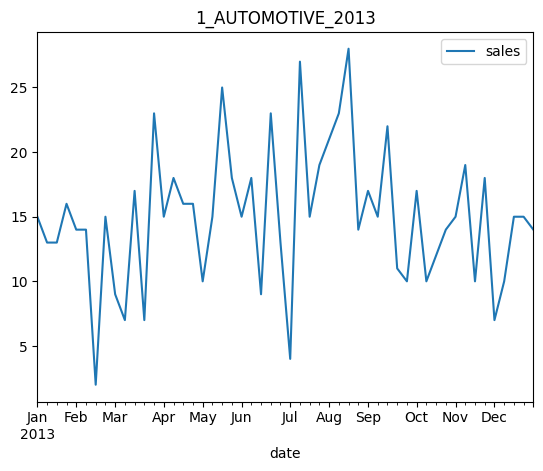

In [6]:
for ts_id in df_dict:
    df_dict[ts_id].plot(x="date", y="sales", title=ts_id)
    break

In [7]:
deleted_ts_count = 0
store_nbr_list, family_list = [], []
for ts_id in list(df_dict.keys()):
    if len(df_dict[ts_id]) < 52:
        del df_dict[ts_id]
        deleted_ts_count += 1
    else:
        store_nbr_list.append(ts_id.split("_")[0])
        family_list.append(ts_id.split("_")[1])
store_nbr_list = np.array(store_nbr_list)
family_list = np.array(family_list)
print(f"Deleted {deleted_ts_count} time series")

Deleted 1782 time series


In [8]:
for i, ts_id in enumerate(df_dict.keys()):
    if i == 0:
        sales_array = df_dict[ts_id]['sales'].to_numpy()
    else:
        sales_array = np.vstack([sales_array, df_dict[ts_id]['sales'].to_numpy()])
print(sales_array.shape)

(7128, 52)


In [9]:
"""
Normalize sales
"""
normed_sales_array = normalize(sales_array, axis=1)

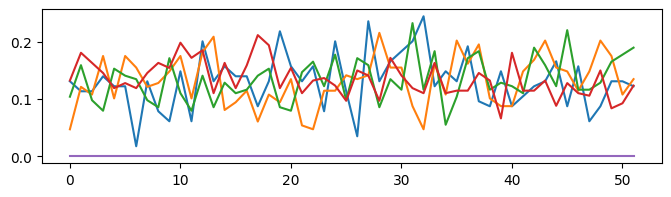

In [10]:
plt.figure(figsize=(8, 2))
for i in range(5):
    plt.plot(normed_sales_array[i, :])
plt.show()

In [11]:
"""
NMF/PCA
"""
method = 'NMF'  # 'PCA', 'NMF'
num_components = 30
if method == 'PCA':
    model = PCA(n_components=num_components)
else:
    model = NMF(n_components=num_components, init="random", random_state=0)
nmf_coef_array = model.fit_transform(normed_sales_array)
print(model.components_.shape)

(30, 52)


/Users/sho/git-portfolio/sales_forecast_walmart/venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


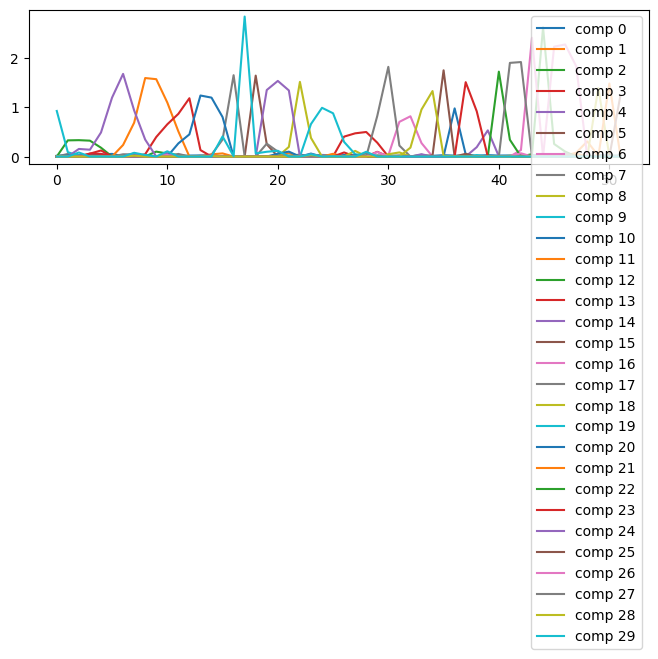

In [12]:
plt.figure(figsize=(8, 2))
for i in range(num_components):
    plt.plot(model.components_[i, :], label=f"comp {i}")
plt.legend()
plt.show()

In [13]:
model.components_.shape

(30, 52)

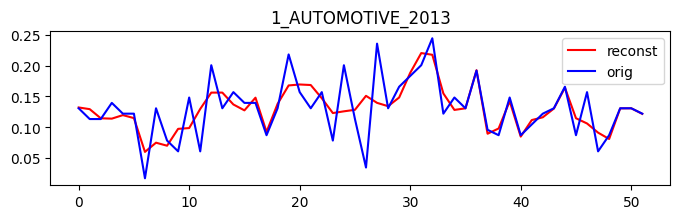

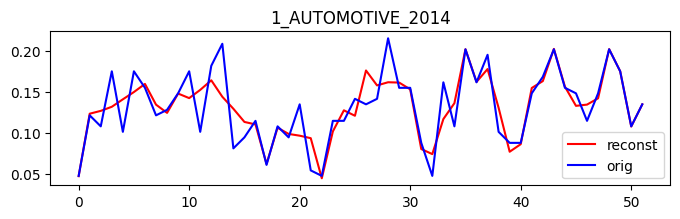

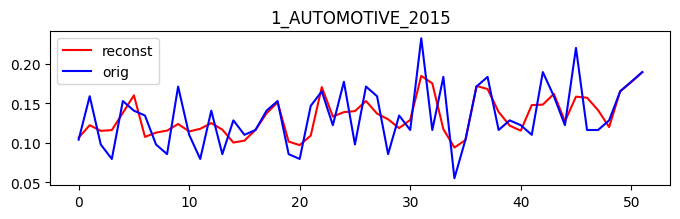

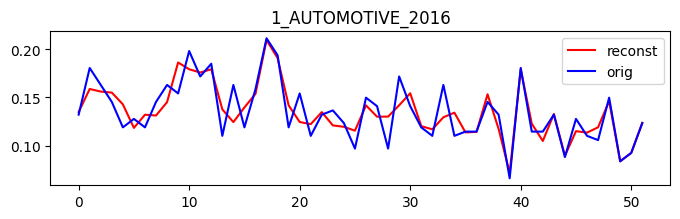

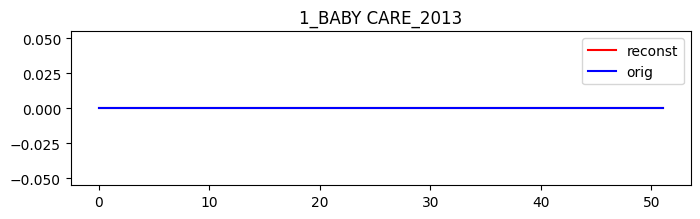

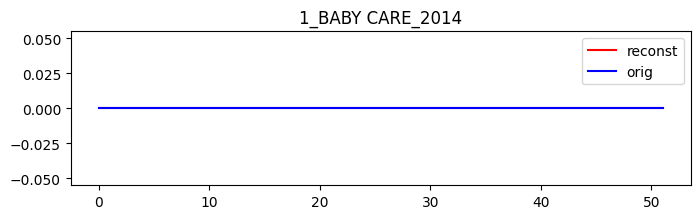

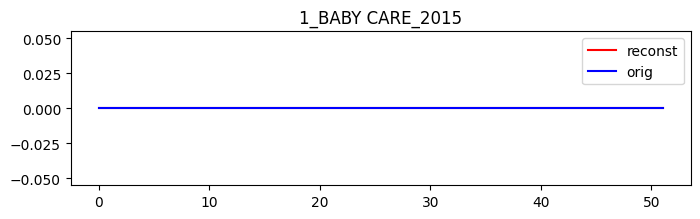

In [14]:
for i, ts_id in enumerate(df_dict.keys()):
    plt.figure(figsize=(8, 2))
    sales = np.zeros(normed_sales_array.shape[1])
    for j in range(num_components):
        sales += nmf_coef_array[i, j] * model.components_[j, :]
    plt.plot(sales, label="reconst", color="r")
    plt.plot(normed_sales_array[i], label="orig", color="b")
    plt.title(ts_id)
    plt.legend()
    plt.show()
    if i > 5:
        break

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 7128 samples in 0.000s...
[t-SNE] Computed neighbors for 7128 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7128
[t-SNE] Computed conditional probabilities for sample 2000 / 7128
[t-SNE] Computed conditional probabilities for sample 3000 / 7128
[t-SNE] Computed conditional probabilities for sample 4000 / 7128
[t-SNE] Computed conditional probabilities for sample 5000 / 7128
[t-SNE] Computed conditional probabilities for sample 6000 / 7128
[t-SNE] Computed conditional probabilities for sample 7000 / 7128
[t-SNE] Computed conditional probabilities for sample 7128 / 7128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.563980
[t-SNE] KL divergence after 300 iterations: 2.367011


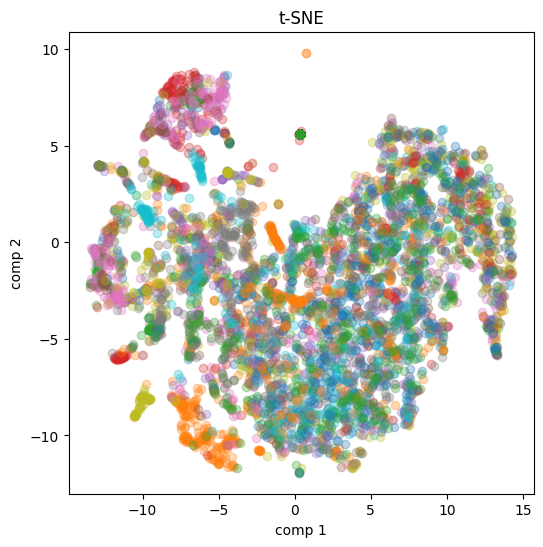

In [40]:
"""
t-SNE
"""
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(nmf_coef_array)
# tsne_results = tsne.fit_transform(normed_sales_array)

plt.figure(figsize=(6, 6))
for family in set(family_list):
    plt.scatter(
        tsne_results[family_list == family, 0],
        tsne_results[family_list == family, 1],
        alpha=0.3,
        label=family,
    )
plt.title("t-SNE")
plt.xlabel("comp 1")
plt.ylabel("comp 2")
# plt.legend()
plt.show()